# 7T micapipe processing | group level

In [47]:
# Set the environment
import os
import glob
import numpy as np
import nibabel as nb
from nibabel.freesurfer.mghformat import load
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from brainspace.datasets import load_conte69
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
import matplotlib.pyplot as plt
from nilearn import plotting # only to plot the matrices
import scipy.stats as ss
import seaborn as sns

# CHECK seaborn color paletes:
#   https://seaborn.pydata.org/tutorial/color_palettes.html


def plot_connectome(mtx, Title='matrix plot', xlab='X', ylab='Y', col='rocket'):
    '''
    This optional function, only plots a connectome as a heatmap
    Parameters
    ----------
    mtx : np.array
    Returns
    -------
    f : plot
    '''
    f, ax = plt.subplots(figsize=(15,10))
    g = sns.heatmap(mtx, ax=ax, cmap=col)
    g.set_xlabel(xlab)
    g.set_ylabel(ylab)
    g.set_title(Title)

# Function 2
def vectorized_mtx(connectome_matrix):
    '''
    This function will: 
    a) vectorize the upper triangle
    b) convert the array into pandas dataframe 
    
    Parameters
    ----------
    connectome_matrix : np.array
    Returns
    -------
    df_feat_flat : Single column pandas dataframe of edges
    
    '''
    
    # Extract lower (or upper) triangle entrees (excluding diagonal)
    tril_idx = np.tril_indices(len(connectome_matrix),k=1) 
    features_flat = connectome_matrix[tril_idx]
    #print(f'Number of features per subject: {len(features_flat)}')
            
    return features_flat

def load_mpc(File, Ndim):
    """Loads and process a functional connectome"""
    
    # load the matrix
    mtx_mpc = np.loadtxt(File, dtype=np.float, delimiter=' ')
    
    # Mirror the matrix
    MPC = np.triu(mtx_mpc,1)+mtx_mpc.T
    
    # Remove the medial wall
    MPC = np.delete(np.delete(MPC, 0, axis=0), 0, axis=1)
    MPC = np.delete(np.delete(MPC, Ndim, axis=0), Ndim, axis=1)
    
    return MPC

def load_gd(File, Ndim):
    """Loads and process a functional connectome"""
    
    # load the matrix
    mtx_gd = np.loadtxt(File, dtype=np.float, delimiter=' ')
    
    # Remove the Mediall Wall
    mtx_gd = np.delete(np.delete(mtx_gd, 0, axis=0), 0, axis=1)
    GD = np.delete(np.delete(mtx_gd, Ndim, axis=0), Ndim, axis=1)
    
    return GD

# Set the working directory to load the helper functions
os.chdir("/host/yeatman/local_raid/rcruces/git_here/micapipe-supplementary")

# Set dataset PNI as working directory
os.chdir('/data_/mica3/BIDS_PNI/derivatives_dev/micapipe_v0.2.0')

# Load conte69
c69_lh, c69_rh = load_conte69()

# Load fsaverage5
fs5_lh = read_surface('/data_/mica3/BIDS_PNI/derivatives_dev/fastsurfer/fsaverage5/surf/lh.pial', itype='fs')
fs5_rh = read_surface('/data_/mica3/BIDS_PNI/derivatives_dev/fastsurfer/fsaverage5/surf/rh.pial', itype='fs')

# Variables
micapipe='/data_/mica1/01_programs/micapipe-v0.2.0'

# Here we define the atlas
atlas='glasser-360' # 'aparc-a2009s' 'schaefer-400'

# Read label for conte69
labels_c69 = np.loadtxt(open(micapipe + '/parcellations/' + atlas + '_conte69.csv'), dtype=np.int)

# mask of the medial wall
mask_c69 = labels_c69 != 0

# Load annotation file in fsaverage5
annot_lh_fs5= nb.freesurfer.read_annot(micapipe + '/parcellations/lh.'+atlas+'_mics.annot')
Ndim = max(np.unique(annot_lh_fs5[0]))
annot_rh_fs5= nb.freesurfer.read_annot(micapipe + '/parcellations/rh.'+atlas+'_mics.annot')[0]+Ndim

/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_30983/2070880055.py:103: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels_c69 = np.loadtxt(open(micapipe + '/parcellations/' + atlas + '_conte69.csv'), dtype=np.int)


# Thickness

In [28]:
th_lh_files=sorted(glob.glob('sub-*/ses-*/anat/surf/morphology/*_space-conte69-32k_desc-lh_thickness.mgh'))
th_rh_files=sorted(glob.glob('sub-*/ses-*/anat/surf/morphology/*_space-conte69-32k_desc-rh_thickness.mgh'))

# Load all the thickness data
Nth=np.hstack(np.concatenate((np.array(load(th_lh_files[0]).get_fdata()), np.array(load(th_rh_files[0]).get_fdata())), axis=0)).shape[1]

th=np.empty([len(th_lh_files), Nth], dtype=float)
for i, f in enumerate(th_lh_files):
    #print(f)
    th[i,:] = np.hstack(np.concatenate((np.array(load(th_lh_files[i]).get_fdata()), np.array(load(th_rh_files[i]).get_fdata())), axis=0))

## Visualize the thickness matrix

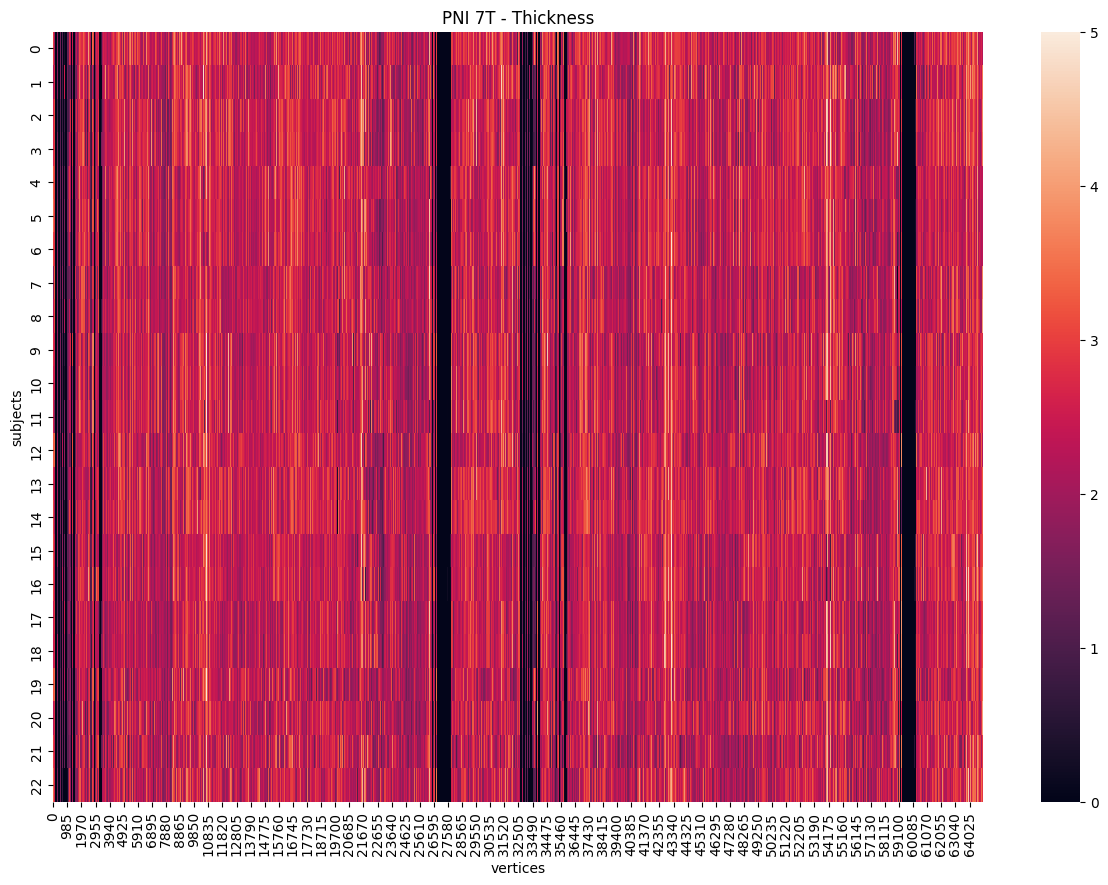

In [48]:
# Visualize the thickness matrix
plot_connectome(th, 'PNI 7T - Thickness', xlab='vertices', ylab='subjects', col='rocket')

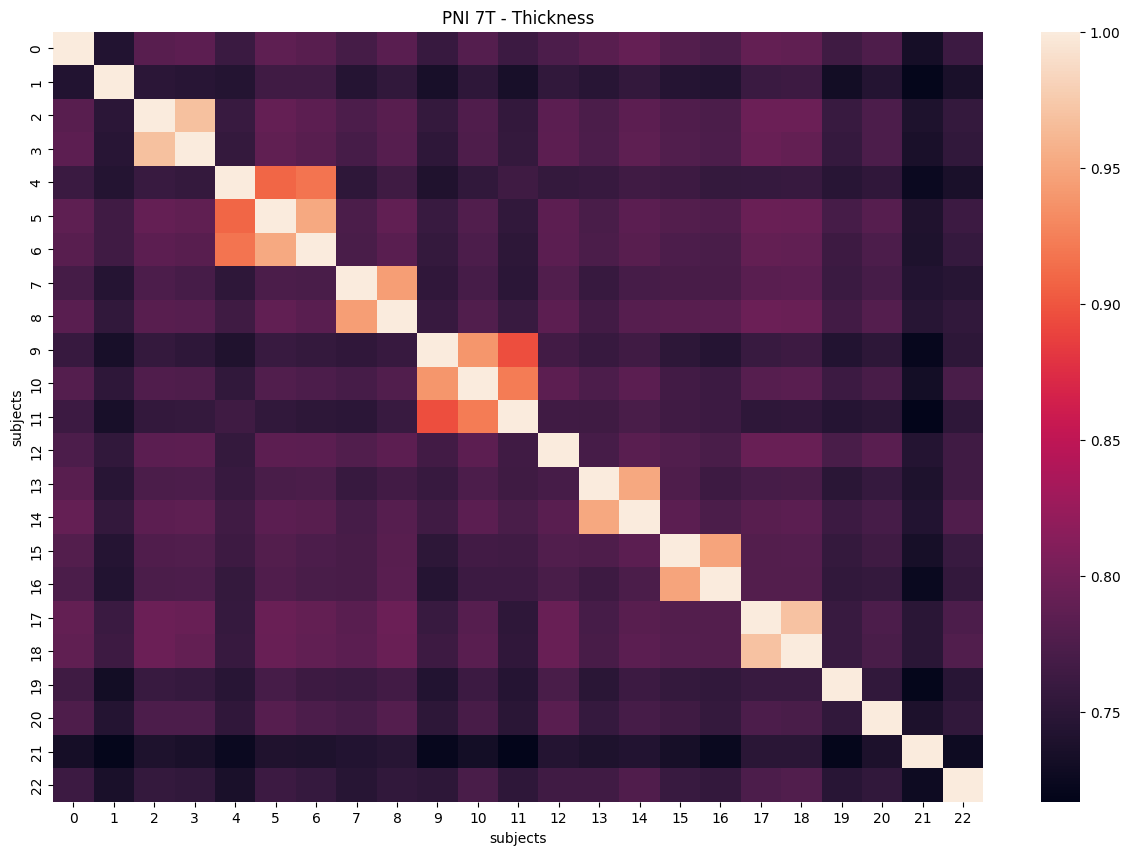

In [49]:
## correlation matrix
th_corr = np.corrcoef(th)
plot_connectome(th_corr, 'PNI 7T - Thickness', xlab='subjects', ylab='subjects')

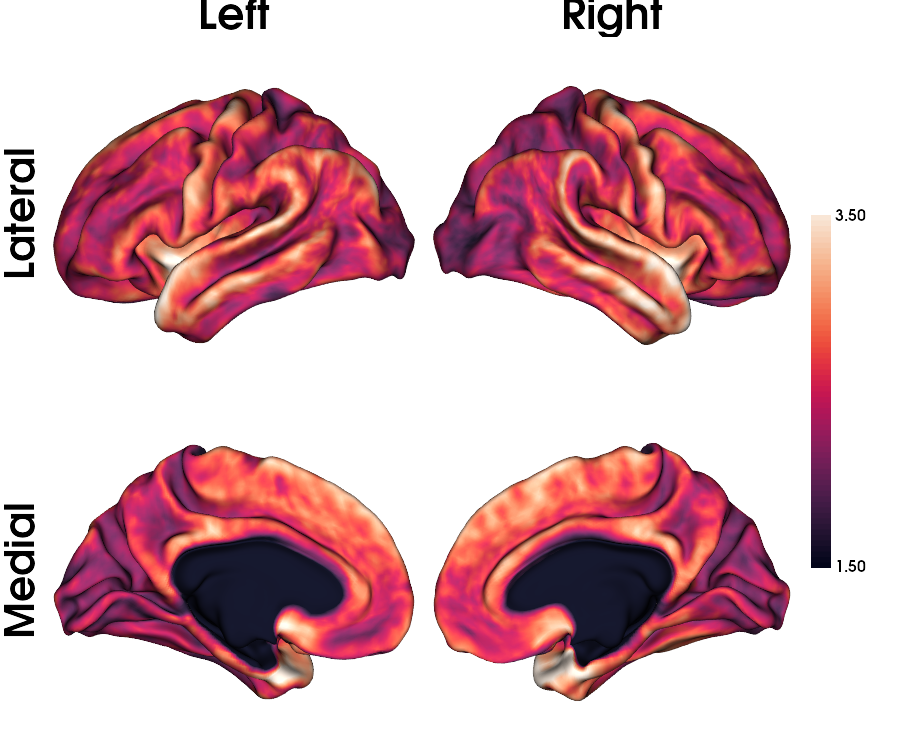

In [50]:
# Mean matrix across the x axis (vertices)
thmean = np.mean(th, axis=0)

# Plot the mean thickness 10mm on conte69 surface
plot_hemispheres(c69_lh, c69_rh, array_name=thmean, cmap='rocket', nan_color=(0, 0, 0, 1),
                      zoom=1.3, size=(900, 750), embed_nb=True,
                      color_bar='right', layout_style='grid', color_range=(1.5, 3.5),
                      label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']},
                      screenshot=False, filename='/home/bic/rcruces/Desktop/PNI_thickness_mean.png')

# Geodesic distance

/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_30983/2070880055.py:75: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mtx_gd = np.loadtxt(File, dtype=np.float, delimiter=' ')


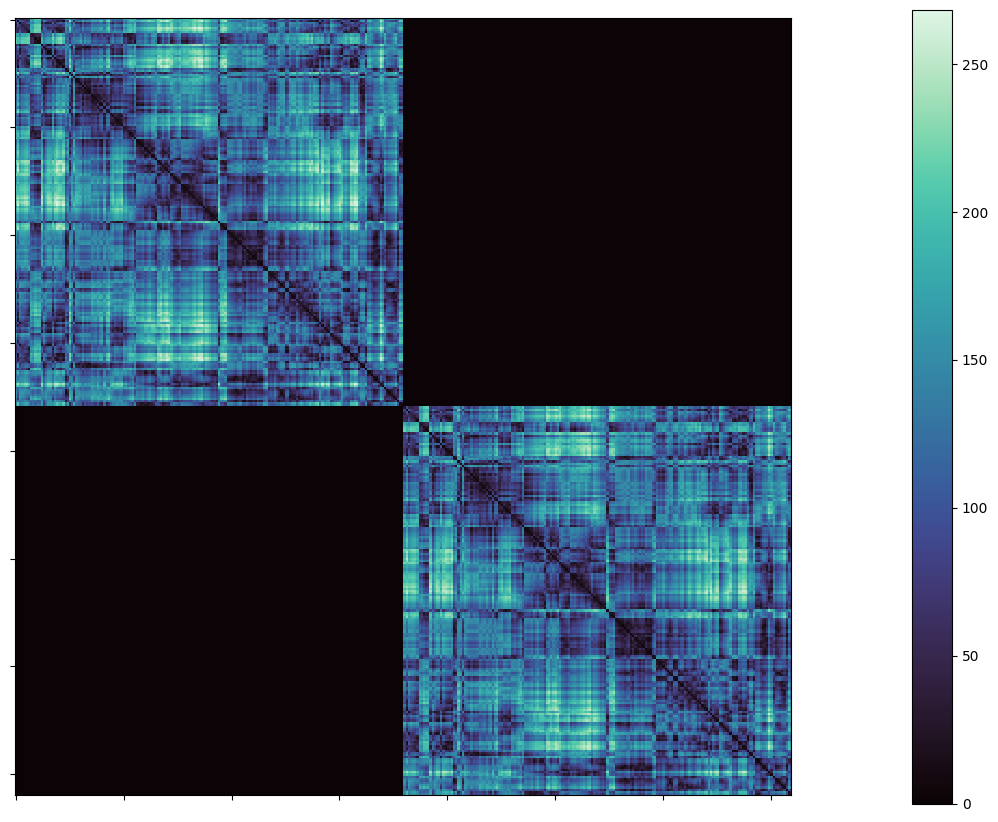

In [51]:
# list of all files
GD_files = sorted(glob.glob('sub-*/ses-*/anat/surf/geo_dist/*_space-fsnative_atlas-'+atlas+'_GD.txt'))

# Load all the  MPC matrices as array
GD=np.empty([Ndim*2, Ndim*2, len(GD_files)], dtype=float)
for i, f in enumerate(GD_files):
    #print(f)
    GD[:,:,i] = load_gd(f, Ndim)
    
# Mean matrix across the z axis
GDmean = np.mean(GD, axis=2)
            
# Plot the log matrix
plotting.plot_matrix(GDmean, figure=(10, 10), labels=None, cmap='mako')

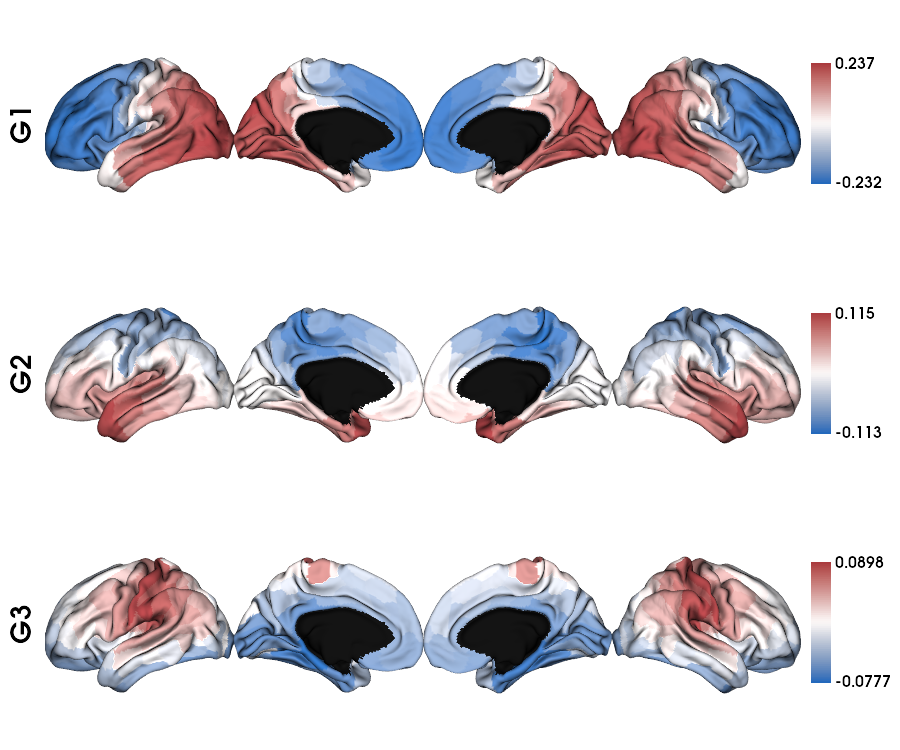

In [63]:
# GD Left hemi
gm_GD_L = GradientMaps(n_components=10, random_state=None, approach='dm', kernel='normalized_angle')
gm_GD_L.fit(GDmean[0:Ndim, 0:Ndim], sparsity=0.8)
            
# GD Right hemi
gm_GD_R = GradientMaps(n_components=10, alignment='procrustes', kernel='normalized_angle'); # align right hemi to left hemi
gm_GD_R.fit(GDmean[Ndim:Ndim*2, Ndim:Ndim*2], sparsity=0.8, reference=gm_GD_L.gradients_)
             
# Left and right gradients concatenated
GD_gradients = np.concatenate((gm_GD_L.gradients_, gm_GD_R.aligned_), axis=0)
# Map gradients to original parcels

grad = [None] * 3
for i, g in enumerate(GD_gradients.T[0:3,:]):
    grad[i] = map_to_labels(g, labels_c69, fill=np.nan, mask=mask_c69)
    
plot_hemispheres(c69_lh, c69_rh, array_name=grad, cmap='vlag', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True,
  color_bar='right', 
  label_text={'left': ['G1', 'G2', 'G3']},
  screenshot=False, filename='/home/bic/rcruces/Desktop/GD_mean'+atlas+'.png')  

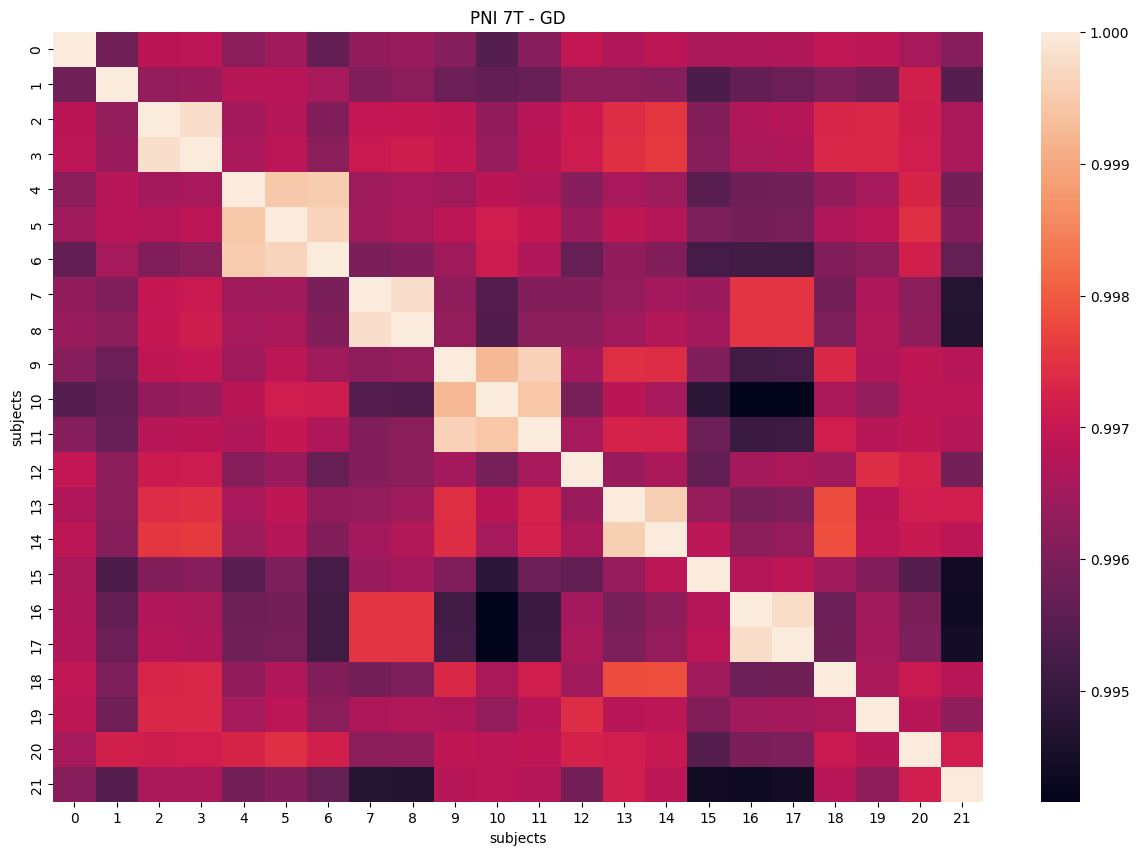

In [62]:
# whitin group similarity matrix
GDtri=np.empty([len(GD_files), vectorized_mtx(GD[:,:,0]).shape[0]], dtype=float)
for i, f in enumerate(GD_files):
    GDtri[i,:]=vectorized_mtx(GD[:,:,i])

# correlation matrix
GD_corr = np.corrcoef(GDtri)
plot_connectome(GD_corr, 'PNI 7T - GD', xlab='subjects', ylab='subjects')

# MP2RAGE qT1 - MPC

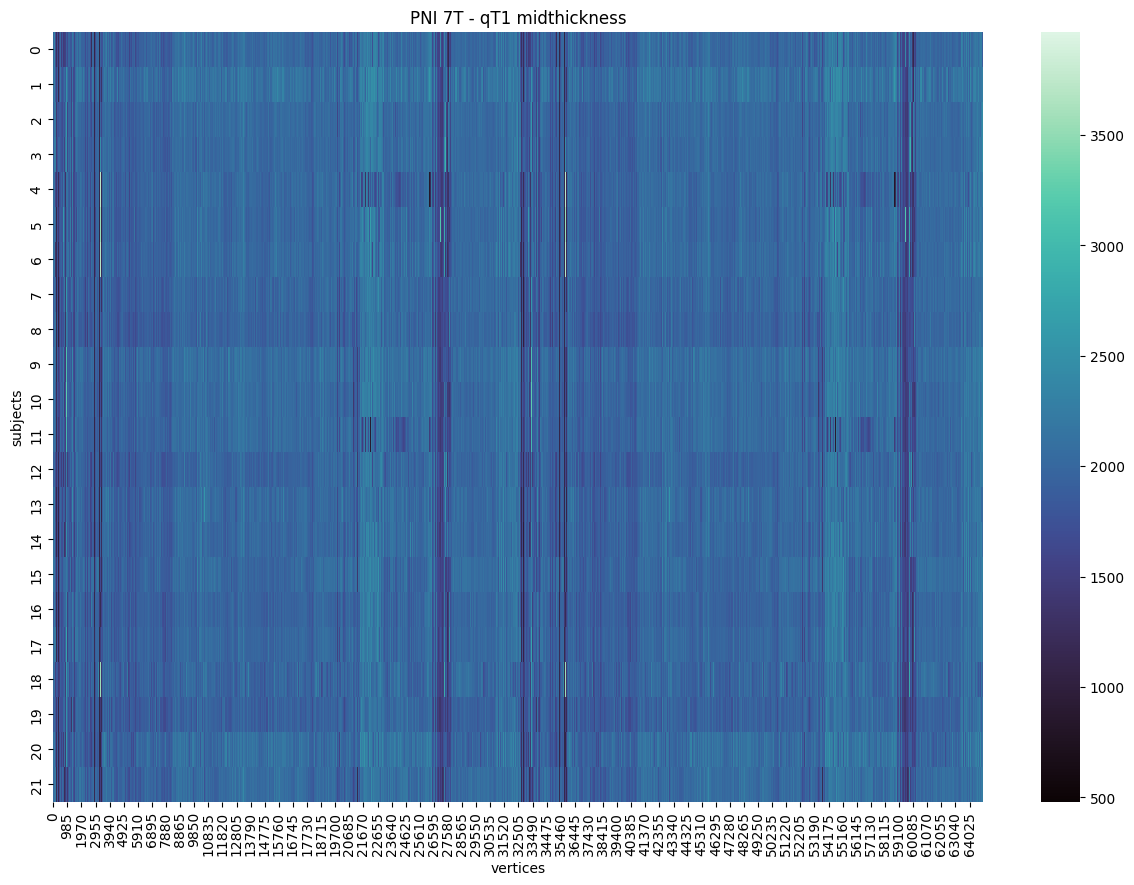

In [57]:
qt1_lh_files=sorted(glob.glob('sub-*/ses-*/anat/surf/micro_profiles/acq-qt1/*_space-conte69-32k_desc-lh_MPC-7.mgh'))
qt1_rh_files=sorted(glob.glob('sub-*/ses-*/anat/surf/micro_profiles/acq-qt1/*_space-conte69-32k_desc-lh_MPC-7.mgh'))

# Load all the thickness data
qt1_dim=np.hstack(np.concatenate((np.array(load(qt1_lh_files[0]).get_fdata()), np.array(load(qt1_rh_files[0]).get_fdata())), axis=0)).shape[1]

qt1=np.empty([len(qt1_lh_files), qt1_dim], dtype=float)
for i, f in enumerate(qt1_lh_files):
    #print(f)
    qt1[i,:] = np.hstack(np.concatenate((np.array(load(qt1_lh_files[i]).get_fdata()), np.array(load(qt1_rh_files[i]).get_fdata())), axis=0))

# Visualize the thickness matrix
plot_connectome(qt1, 'PNI 7T - qT1 midthickness', xlab='vertices', ylab='subjects', col='mako')

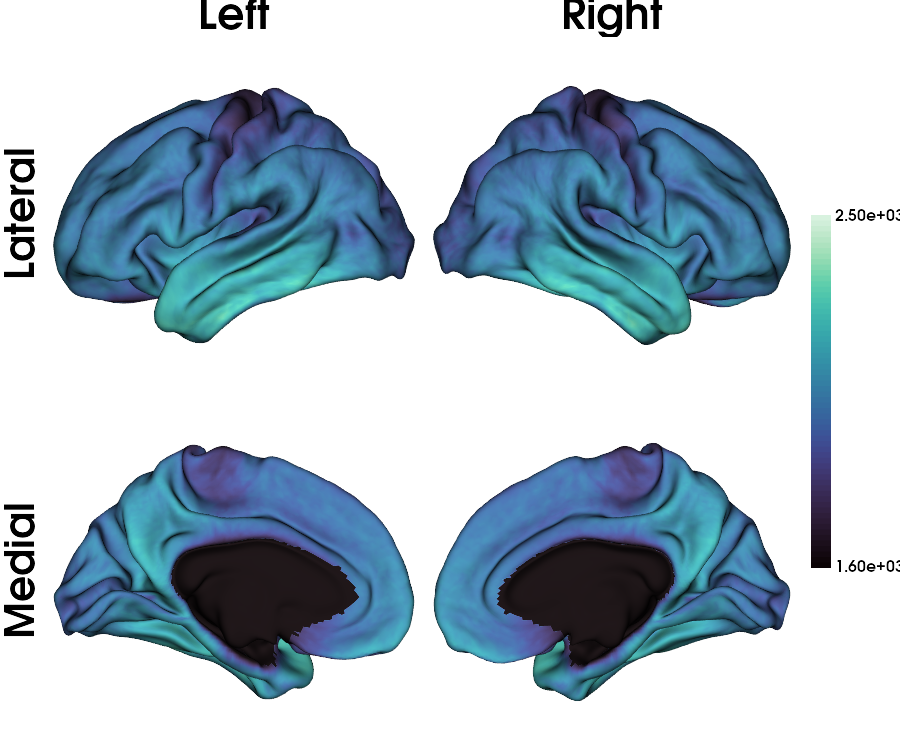

In [58]:
# Mean matrix across the x axis (vertices)
qt1mean = np.mean(qt1, axis=0)

# Plot the mean thickness 10mm on conte69 surface
plot_hemispheres(c69_lh, c69_rh, array_name=qt1mean*mask_c69, cmap='mako', nan_color=(0, 0, 0, 1),
                      zoom=1.3, size=(900, 750), embed_nb=True,
                      color_bar='right', layout_style='grid', color_range=(1600, 2500),
                      label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']},
                      screenshot=False, filename='/home/bic/rcruces/Desktop/PNI_qt1_mean.png')

/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_30983/2070880055.py:60: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mtx_mpc = np.loadtxt(File, dtype=np.float, delimiter=' ')


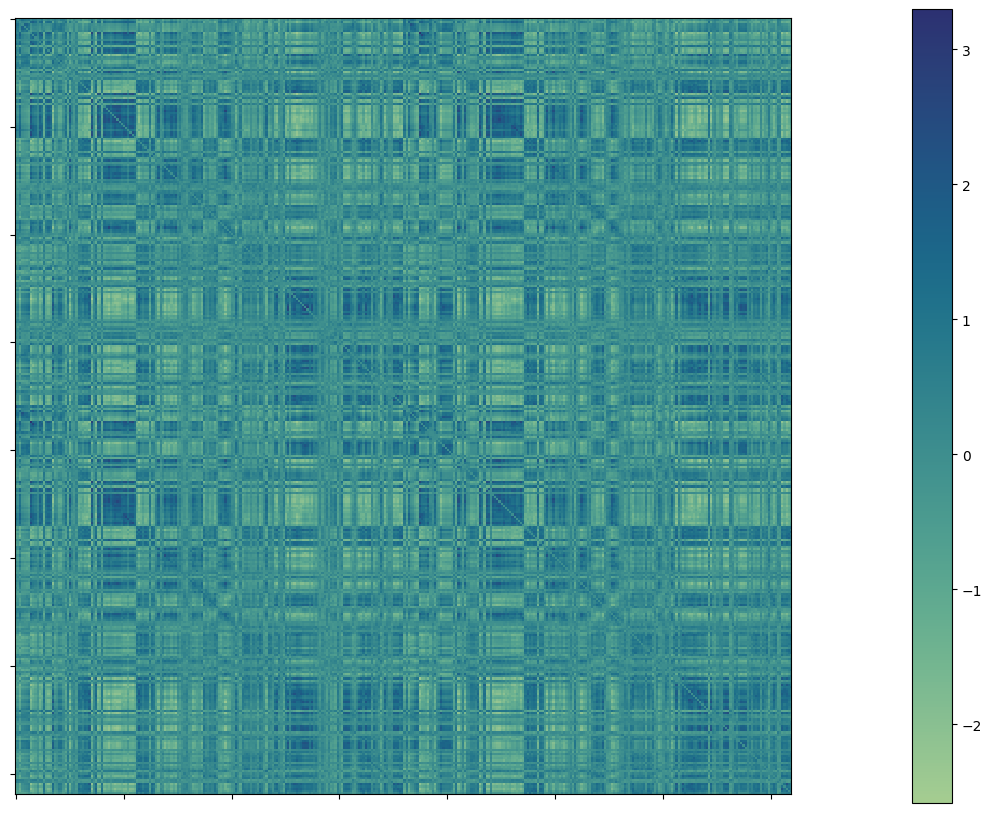

In [59]:
# list of all files
MPC_files = sorted(glob.glob('sub-*/ses-*/anat/surf/micro_profiles/acq-qt1/*_space-fsnative_atlas-'+atlas+'_desc-MPC.txt'))

# Load all the  MPC matrices as array
MPC=np.empty([Ndim*2, Ndim*2, len(MPC_files)], dtype=float)
for i, f in enumerate(MPC_files):
    #print(f)
    MPC[:,:,i] = load_mpc(f, Ndim)

# Mean matrix across the z axis
MPCmean = np.mean(MPC, axis=2)

# Plot the matrix
plotting.plot_matrix(MPCmean, figure=(10, 10), labels=None, cmap='crest')


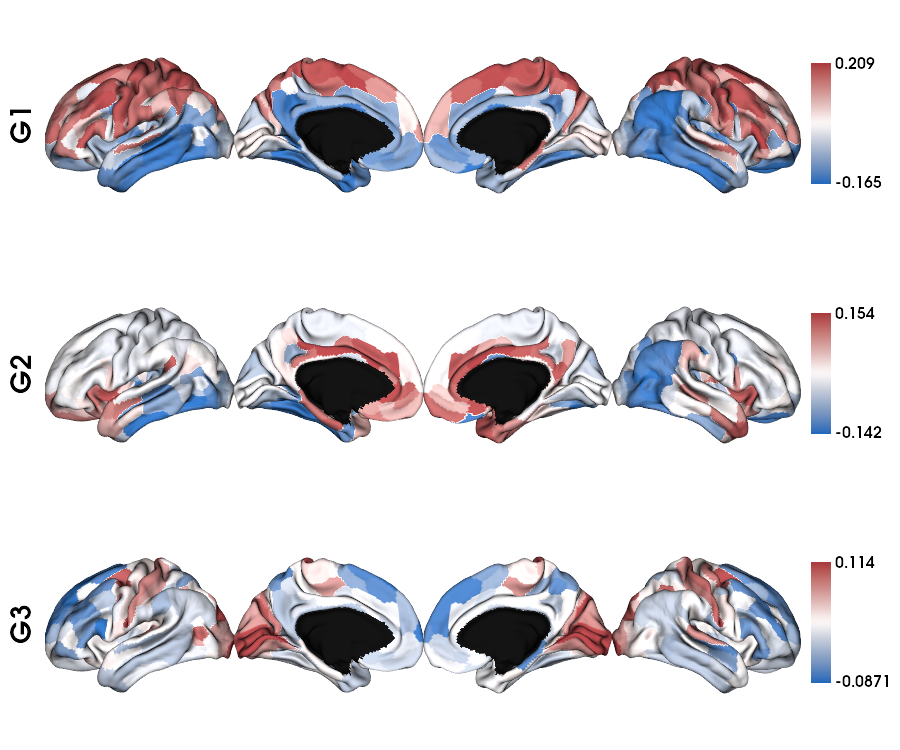

In [61]:
# Calculate the gradients
MPCgm = GradientMaps(n_components=10, random_state=None, approach='dm', kernel='normalized_angle')
MPCgm.fit(MPCmean, sparsity=0.9)

# Map gradients to original parcels
# other color 'RdYlBu_r'
grad = [None] * 3
for i, g in enumerate(MPCgm.gradients_.T[0:3,:]):
    grad[i] = map_to_labels(g, labels_c69, fill=np.nan, mask=mask_c69)
plot_hemispheres(c69_lh, c69_rh, array_name=grad, cmap='vlag', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True,
  color_bar='right', 
  label_text={'left': ['G1', 'G2', 'G3']},
  screenshot=False, filename='/home/bic/rcruces/Desktop/MPC_mean'+atlas+'.png')  

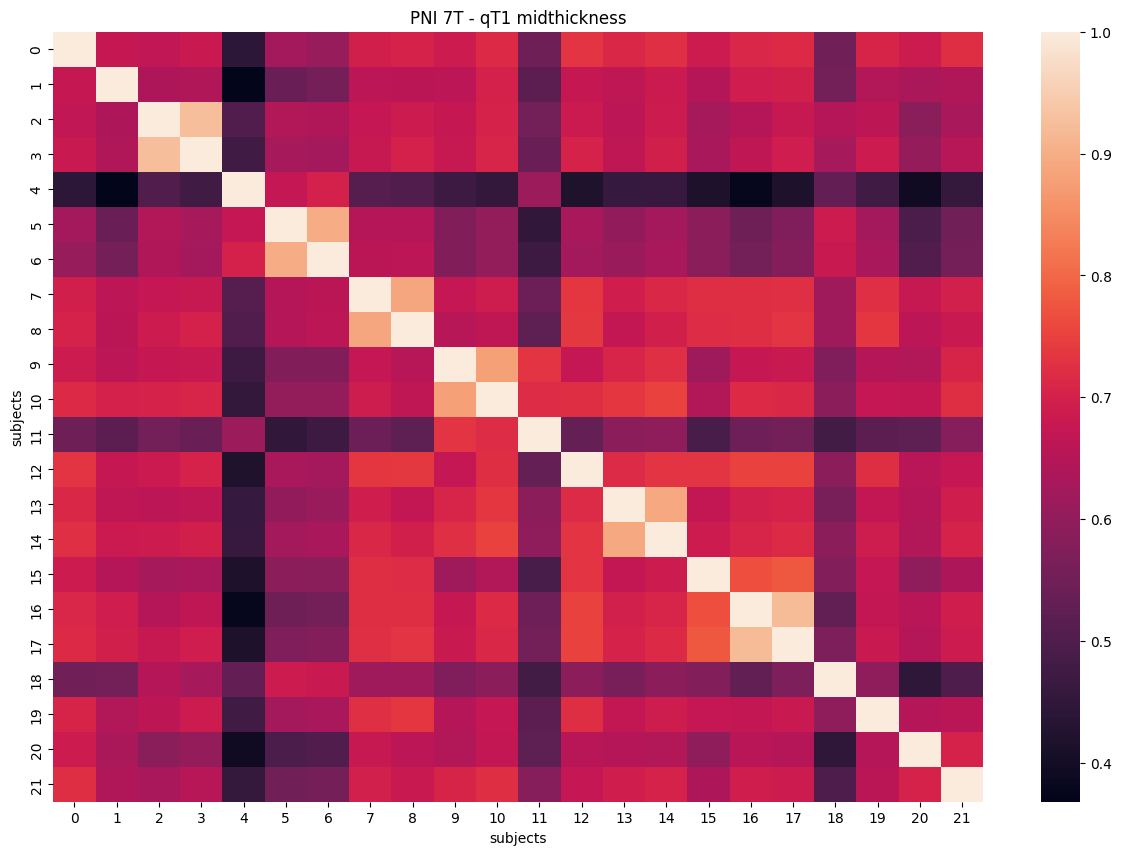

In [64]:
# correlation matrix
qt1_corr = np.corrcoef(qt1)
plot_connectome(qt1_corr, 'PNI 7T - qT1 midthickness', xlab='subjects', ylab='subjects')

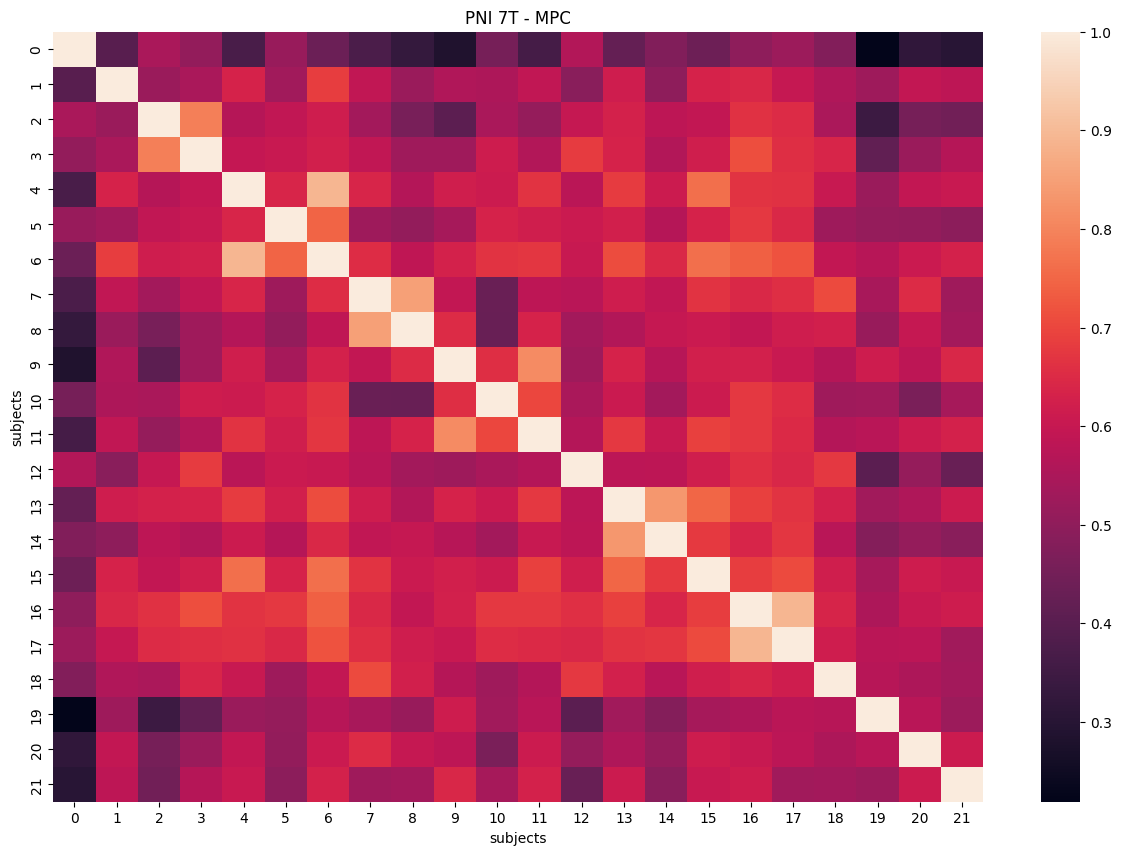

In [36]:
# Subject similarity matrix
MPCcol = np.mean(MPC, axis=0)
MPC_corr = np.corrcoef(MPCcol.T)
plot_connectome(MPC_corr, 'PNI 7T - MPC', xlab='subjects', ylab='subjects')

# Functional gradients